In [1]:
#Importing all require packages and libraries
import cython
import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit.strategies import SOBO, MultitoSingleObjective
import numpy as np
import pandas as pd
import pkg_resources
import pathlib
import os
import matplotlib.pyplot as plt
import math

In [2]:
#Reading the input data (Boundaries.csv and Data.csv)
BASE_PATH = pathlib.Path("F:/Python Programs/DrewAWL")
DATA_PATH = BASE_PATH / "Data"
MODEL_PATH = BASE_PATH / "Models"
ITER_PATH = BASE_PATH / "IterData"
InitialBounds_name = "DrewBounds.csv"
WorkData_name = "DrewAWL_ExpRAW_NoOut.csv"
Project_name = "AWL_Optimization"

InitialBounds_df = pd.read_csv(DATA_PATH / InitialBounds_name)

In [3]:
InitialBounds_df

,Condition,Type,Categories,BoundaryMin,BoundaryMax,Description,Maximize
0,Res_Time,Continuous,NaN,20,100,Residence Time in total reactors,NaN
1,TempZ1,Continuous,NaN,10,30,Temperature of the first crystallizer,NaN
2,TempZ2,Continuous,NaN,0,10,Temperature of the second crystallizer,NaN
3,AF,Objective,NaN,0,1,PSD,True


In [4]:
#Creating the domain utilizing the Boundaries.csv
domain = Domain()
Objective_df = pd.DataFrame()
Objective_df = DataSet.from_df(Objective_df)
InputCount = 0
OutputCount = 0

for idx, row in InitialBounds_df.iterrows():
    name = row[0]  
    description = row[5]  
    data_type = row['Type']
    
    if data_type == 'Categorical':
        levels = row[2].split(',')  
        
        domain += CategoricalVariable(
            name = name,
            description = description,
            levels = levels
        )
        InputCount += 1
        
    elif data_type == 'Continuous':
        bounds = [row[3], row[4]]
        
        domain += ContinuousVariable(
            name = name,
            description = description,
            bounds = bounds
        )
        InputCount += 1
        
    elif data_type == 'Objective':
        bounds = [row[3], row[4]]
        maximize = row[6]
        
        domain += ContinuousVariable(
            name = name,
            description = description,
            bounds = bounds,
            is_objective = True,
            maximize = maximize
        )
        OutputCount += 1

        Objective_df[(name, "DATA")] = ""

In [5]:
domain

Name,Type,Description,Values
Res_Time,"continuous, input",Residence Time in total reactors,"[20,100]"
TempZ1,"continuous, input",Temperature of the first crystallizer,"[10,30]"
TempZ2,"continuous, input",Temperature of the second crystallizer,"[0,10]"
AF,"continuous, maximize objective",PSD,"[0,1]"


In [7]:
WorkData_df = DataSet.read_csv(DATA_PATH / WorkData_name) 

strategy = SOBO(
            domain = domain,
            acquisition_type = "EI"
        )

In [8]:
WorkData_df

,Res_Time,TempZ1,TempZ2,strategy,AF
0,60,15,5,LHS,-0.0695
1,60,15,5,LHS,-0.081
2,39,27,4,LHS,-0.3615
3,33,11,1,LHS,0.06
4,81,23,7,LHS,-0.176
5,87,15,9,LHS,-0.1165
6,17,10,6,LHS,-0.2595
7,30,20,10,LHS,0.031
8,75,30,10,LHS,-0.295


In [9]:
NewIt = strategy.suggest_experiments(
            num_experiments = 10,
            prev_res = WorkData_df
)

In [10]:
NewIt

,Res_Time,TempZ1,TempZ2,strategy
0,32.418830,11.409335,1.418553,Single-objective BayOpt
1,71.050130,25.274918,3.246024,Single-objective BayOpt
2,76.873325,10.199366,7.223468,Single-objective BayOpt
3,60.039650,13.509176,5.169600,Single-objective BayOpt
4,84.621409,14.010914,7.654196,Single-objective BayOpt
5,25.494308,18.648066,5.777551,Single-objective BayOpt
6,79.030406,24.274983,3.474008,Single-objective BayOpt
7,22.913942,13.931742,4.195715,Single-objective BayOpt
8,81.844696,29.469039,3.679686,Single-objective BayOpt
9,52.654174,14.187389,9.405188,Single-objective BayOpt


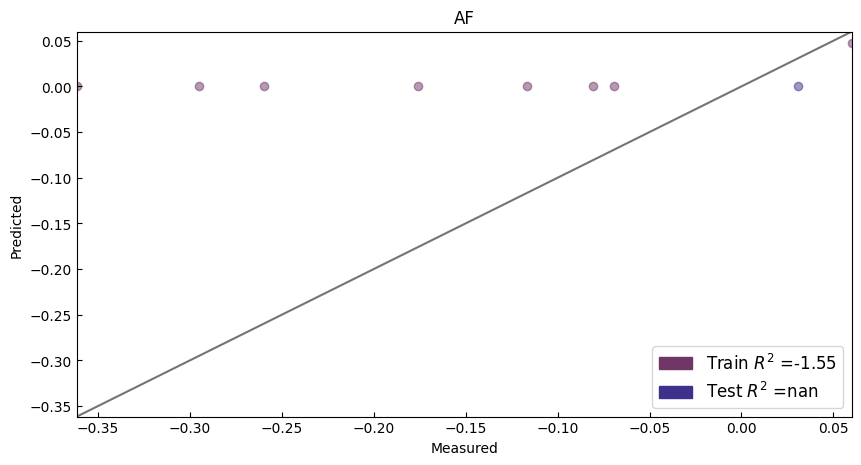

In [11]:
#temp
Exp_num = 9

emul = ExperimentalEmulator(
    model_name = Project_name,
    domain = domain,
    dataset = WorkData_df
)

emul.train(
    max_epochs = 1000,
    cv_fold = 5,
    random_state = 410,
    test_size = 0.1,
    verbose = 0
)

fig, ax = emul.parity_plot(include_test=True)

Prediction_raw = emul.run_experiments(NewIt)

In [12]:
Prediction_raw

,Res_Time,TempZ1,TempZ2,AF,computation_t,experiment_t,strategy
0,32.41883,11.409335,1.418553,0.028501,0.0,0.015622,Single-objective BayOpt
1,71.05013,25.274918,3.246024,0.0,0.0,0.01562,Single-objective BayOpt
2,76.873325,10.199366,7.223468,0.0,0.0,0.015628,Single-objective BayOpt
3,60.03965,13.509176,5.1696,0.0,0.0,0.0,Single-objective BayOpt
4,84.621409,14.010914,7.654196,0.0,0.0,0.0,Single-objective BayOpt
5,25.494308,18.648066,5.777551,0.0,0.0,0.025681,Single-objective BayOpt
6,79.030406,24.274983,3.474008,0.0,0.0,0.010198,Single-objective BayOpt
7,22.913942,13.931742,4.195715,0.0,0.0,0.010464,Single-objective BayOpt
8,81.844696,29.469039,3.679686,0.0,0.0,0.008175,Single-objective BayOpt
9,52.654174,14.187389,9.405188,0.0,0.0,0.016358,Single-objective BayOpt
